<a href="https://colab.research.google.com/github/FatemehAbediK/signal-processing-EEG/blob/main/eeg_numpy_aarays_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
main_dir = '/content/drive/MyDrive/dataset files/eeg-consent/AISContest_Data'

In [6]:
# List the contents of the directory to make sure it points to the right place
print(os.listdir(main_dir))

['1', '0', '3', '2', '4']


In [7]:
# Initialize lists to store the data and labels
data = []
labels = []

# Iterate through each folder in the main directory
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)

    # Check if it is a directory (skip files)
    if os.path.isdir(folder_path):
        # The folder name will be used as the label
        label = folder_name

        # Iterate through each file in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.npy'):
                file_path = os.path.join(folder_path, file_name)

                # Load the .npy file
                file_data = np.load(file_path)

                # Append the data and corresponding label to the lists
                data.append(file_data)
                labels.append(label)

# Convert lists to numpy arrays (optional)
data = np.array(data)
labels = np.array(labels)

# Check the first few files and their labels to ensure everything is correct
print(data.shape)  # Shape of the data (number of files, shape of each .npy)
print(labels[:5])  # First 5 labels to verify they're correctly assigned

(5629, 51, 59, 1)
['1' '1' '1' '1' '1']


In [8]:
print(data[0])  # Display the first sample
print(labels[0])  # Display the label for the first sample


[[[7.59610615e-06]
  [2.95189310e-06]
  [7.69649020e-06]
  ...
  [2.25728121e-05]
  [6.03978996e-05]
  [5.18709476e-05]]

 [[1.40866506e-05]
  [5.32253911e-06]
  [9.80565096e-06]
  ...
  [3.51300818e-05]
  [6.31155574e-05]
  [4.77625244e-05]]

 [[1.72391155e-05]
  [7.92305901e-06]
  [7.13584942e-06]
  ...
  [1.72639708e-05]
  [1.67320854e-05]
  [7.05703926e-05]]

 ...

 [[8.44561710e-08]
  [4.87924921e-08]
  [4.62181642e-08]
  ...
  [1.06191933e-07]
  [7.02747289e-08]
  [8.57741960e-08]]

 [[5.01691515e-08]
  [3.74291188e-08]
  [7.96119616e-08]
  ...
  [2.49364436e-08]
  [9.44725202e-08]
  [1.80483846e-07]]

 [[4.08063444e-08]
  [2.30283889e-08]
  [2.22213787e-08]
  ...
  [8.57444561e-08]
  [8.00021843e-08]
  [1.55265099e-07]]]
1


In [9]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

# Normalize the EEG data (min-max normalization)
data = data / np.max(data, axis=(1, 2), keepdims=True)  # Normalize for each sample

# Encode the labels (assuming labels are categorical)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # Convert categorical labels to numeric (0, 1, 2, 3, 4)

# One-hot encode the labels for multi-class classification
y = to_categorical(y, num_classes=5)  # 5 classes

# Inspect the shape of the labels
print(y.shape)  # (n_samples, 5)

(5629, 5)


In [34]:
from sklearn.model_selection import train_test_split

# Split the data with stratification to ensure each class is proportionally represented in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, stratify=y)

# Inspect the shape of the splits
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Inspect the class distribution in both train and test sets
print("Training labels distribution:", np.sum(y_train, axis=0))
print("Testing labels distribution:", np.sum(y_test, axis=0))

(4503, 51, 59, 1) (1126, 51, 59, 1)
(4503, 5) (1126, 5)
Training labels distribution: [2169.  190. 1412.  398.  334.]
Testing labels distribution: [543.  47. 353.  99.  84.]


In [35]:
import pickle

# Save the splits to files
with open('data_splits.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

print("Data splits saved successfully!")


Data splits saved successfully!


#FIESRT MODEL

In [19]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.5 MB/s eta 0:00:00


In [30]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    model = Sequential()

    # Hyperparameters for convolutional layers
    for i in range(hp.Int('conv_layers', 1, 3)):  # Number of convolutional layers
        kernel_size_choice = hp.Choice(f'kernel_size_{i}', [3, 5])  # Single int value
        model.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', [32, 64, 128]),
            kernel_size=(kernel_size_choice, kernel_size_choice),  # Convert int to tuple
            activation='relu',
            input_shape=(51, 59, 1) if i == 0 else None
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout for regularization
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', 64, 256, step=64),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dense_dropout', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



In [31]:
from keras_tuner import RandomSearch

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='eeg_classification'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print("Conv Layers:", best_hps.get('conv_layers'))
for i in range(best_hps.get('conv_layers')):
    print(f"Filters (Layer {i+1}):", best_hps.get(f'filters_{i}'))
    print(f"Kernel Size (Layer {i+1}):", (best_hps.get(f'kernel_size_{i}'), best_hps.get(f'kernel_size_{i}')))
print("Dropout:", best_hps.get('dropout'))
print("Dense Units:", best_hps.get('dense_units'))
print("Dense Dropout:", best_hps.get('dense_dropout'))
print("Learning Rate:", best_hps.get('learning_rate'))


Trial 10 Complete [00h 00m 30s]
val_accuracy: 0.49056604504585266

Best val_accuracy So Far: 0.49056604504585266
Total elapsed time: 00h 07m 42s
Best Hyperparameters:
Conv Layers: 3
Filters (Layer 1): 32
Kernel Size (Layer 1): (3, 3)
Filters (Layer 2): 32
Kernel Size (Layer 2): (3, 3)
Filters (Layer 3): 32
Kernel Size (Layer 3): (3, 3)
Dropout: 0.30000000000000004
Dense Units: 256
Dense Dropout: 0.30000000000000004
Learning Rate: 0.001


In [32]:
# Build the best model
final_model = tuner.hypermodel.build(best_hps)

# Train the model
history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate on test data
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.4272 - loss: 1.3589 - val_accuracy: 0.4895 - val_loss: 1.2386
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4932 - loss: 1.2501 - val_accuracy: 0.4895 - val_loss: 1.2350
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4797 - loss: 1.2806 - val_accuracy: 0.4895 - val_loss: 1.2358
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5007 - loss: 1.2462 - val_accuracy: 0.4895 - val_loss: 1.2349
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4853 - loss: 1.2514 - val_accuracy: 0.4895 - val_loss: 1.2367
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4650 - loss: 1.2924 - val_accuracy: 0.4895 - val_loss: 1.2350
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4821 - loss: 1.2734 - val_accuracy: 0.4895 - val_loss: 1.2343
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4931 - loss: 1.2459 - val_accuracy: 0

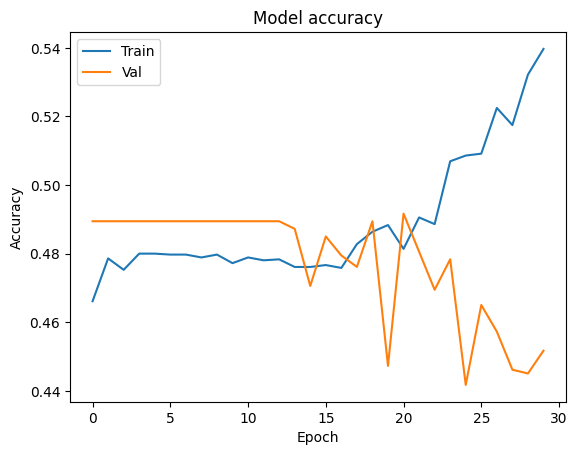

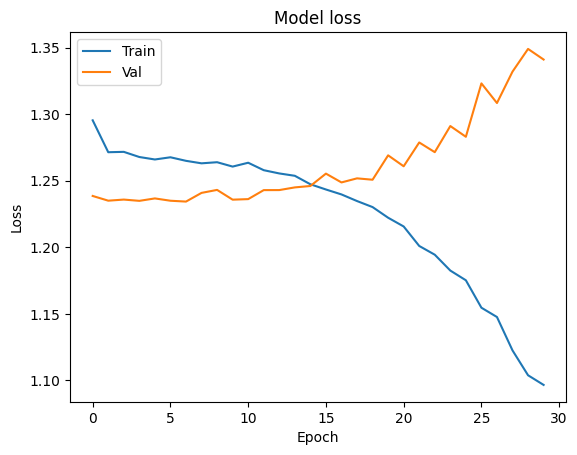

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


#SECOND MODEL

In [36]:
with open('data_splits.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

print("Data splits loaded successfully!")


Data splits loaded successfully!


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Add more convolutional layers with more filters
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

# Add max-pooling layers
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and add Dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Increase dropout to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer (adjust the number of units based on your problem)
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback to reduce learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model with the learning rate scheduler
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=32,
                    verbose=1,
                    callbacks=[lr_scheduler])


Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.3347 - loss: 13.9886 - val_accuracy: 0.4895 - val_loss: 25.5974 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4677 - loss: 1.4202 - val_accuracy: 0.4895 - val_loss: 33.1218 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4764 - loss: 1.3227 - val_accuracy: 0.4895 - val_loss: 26.8799 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4691 - loss: 1.2864 - val_accuracy: 0.4717 - val_loss: 15.1731 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4774 - loss: 1.2819 - val_accuracy: 0.3230 - val_loss: 6.5737 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4855 - loss: 1.2759 - val_accuracy: 0.4750 - val_loss: 1.3305 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4762 - l

In [39]:
from tensorflow.keras.regularizers import l2

# Add L2 regularization to layers
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())

# Max pooling, flatten, and dense layers
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [40]:
from tensorflow.keras.layers import BatchNormalization

# Add Batch Normalization after each convolutional layer (already shown above)
model.add(BatchNormalization())


In [41]:
from keras_tuner import Hyperband

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'nadam']),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Run Hyperband for hyperparameter optimization
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    directory='hyperband_dir',
    project_name='eeg_model'
)

tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test))


Trial 8 Complete [00h 00m 29s]
val_accuracy: 0.47335702180862427

Best val_accuracy So Far: 0.4849023222923279
Total elapsed time: 00h 02m 49s
